In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [2]:
a = 0.8
b = 0.2
V = 35 * 1000
C0 = 3
Ck = 0.1

In [3]:
# v - objetosc krwi do filtracji
# k - klirens
# c0 - poczatkowa stezenie 
# ck - stezenie do ktorego dazymy
def time_to_ck(V, K):
    t = (V/K) * np.log(C0/Ck)
    return t

In [4]:
# Qb - przeplyw krwi w trakcie dializy
# Qd - przeplyw dializatu
def klirens(Qb, Qd):
    K = a * Qb + b * Qd
    return K

In [5]:
def wrapper(x):
    Qb = x[0]
    Qd = x[1]
    
    K_actual = klirens(Qb, Qd)
    t = time_to_ck(V, K_actual)
    return t

In [11]:
bounds = [(100, 400), (300, 800)]
res = optimize.minimize(wrapper, x0=[200, 500], bounds=bounds)
print(f"Qb, Qd = ({res.x})")
print(f"t = {res.fun}")

optimize_qb = res.x[0]
optimize_qd = res.x[1]

Qb, Qd = ([400. 800.])
t = 248.00397574619885


Text(0, 0.5, 'objetosc [ml]')

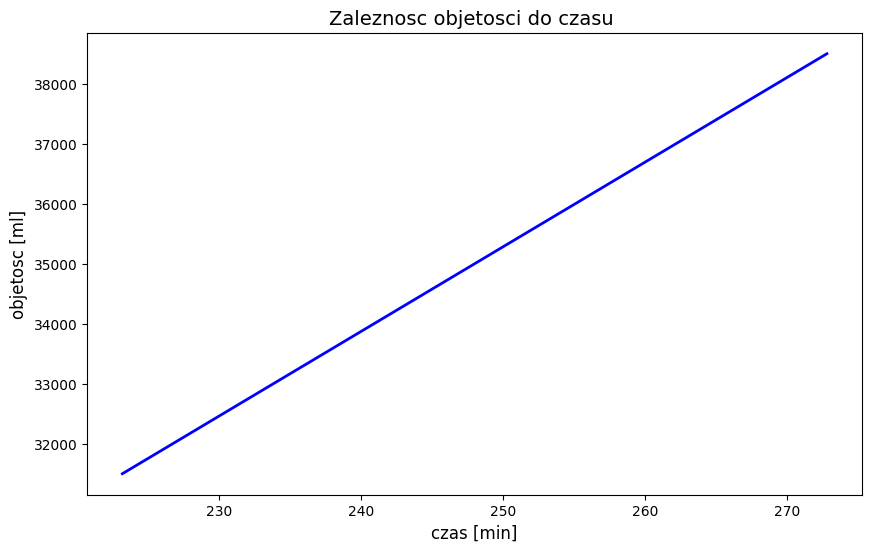

In [28]:
V_list = np.linspace(V - (0.1 * V), V + (0.1 * V), 100)
times = []

K_actual = klirens(optimize_qb, optimize_qd)

for v_l in V_list:
    t = time_to_ck(v_l, K_actual)
    times.append(t)
    
plt.figure(figsize=(10, 6))

plt.plot(times, V_list, label='Czas dializy', color='blue', linewidth=2)

plt.title('Zaleznosc objetosci do czasu ', fontsize=14)
plt.xlabel('czas [min]', fontsize=12)
plt.ylabel('objetosc [ml]', fontsize=12)

In [29]:
k = 0.5
Cb0 = 100.0
Ct0 = 0.0
y0 = [Cb0, Ct0]
final_cb = 20.0

In [30]:
def two_compartment_model(t, y, K):
    Cb, Ct = y
    
    dCb = (-K/V) * Cb + k * (Ct - Cb)
    dCt = k * (Cb - Ct)
    return [dCb, dCt]

In [31]:
from scipy.integrate import solve_ivp

In [32]:
def check(t, y, K):
    Cb = y[0]
    return Cb - final_cb

check.terminal = True
check.direction = -1

In [33]:
def optimize_two_compartment(params):
    Qb, Qd = params

    if Qb <= 0 or Qd <= 0: return 1e6
    
    K_temp = klirens(Qb, Qd)
    
    res = solve_ivp(two_compartment_model, (0, 1000), [Cb0, Ct0], args=(K_temp,), events=check, method='RK45')
    
    if len(res.t_events[0]) > 0:
        time_success = res.t_events[0][0]
        return time_success
    else:
        return 1000.0

In [ ]:
bounds = [(100, 400), (300, 800)]
x0 = [200, 500]

res = optimize.minimize(optimize_two_compartment, x0=x0, bounds=bounds, method='Nelder-Mead')
print(f"Qb: {res.x[0]:.2f}")
print(f"Qd: {res.x[1]:.2f}")
print(f"t do {final_cb}: {res.fun:.2f} minut")

optimize_qb = res.x[0]
optimize_qd = res.x[1]

Qb: 400.00
Qd: 800.00
t do 20.0: 132.51 minut


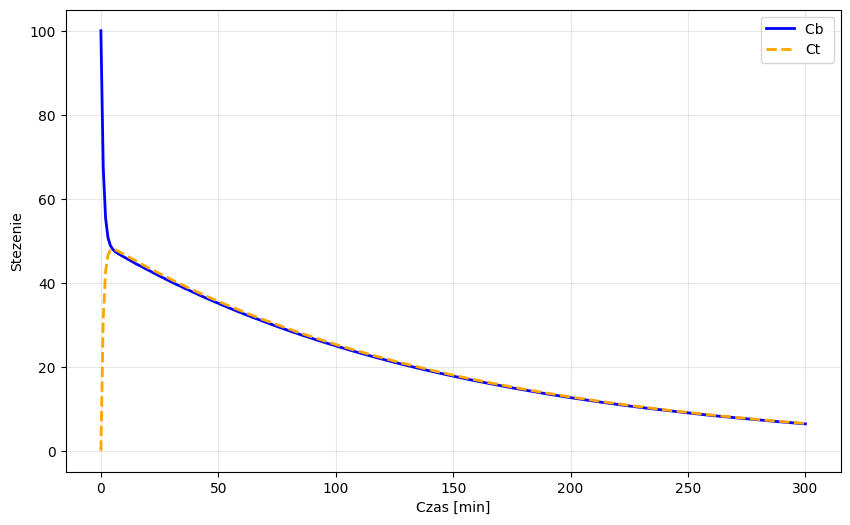

In [39]:
V_list = np.linspace(V - (0.1 * V), V + (0.1 * V), 100)
times = []

K_actual = klirens(optimize_qb, optimize_qd)

sol = solve_ivp(
    two_compartment_model, [0,1000], [Cb0, Ct0], args=(K_actual,), method='RK45',dense_output=True)

t_plot = np.linspace(0, 300, 300)
y_plot = sol.sol(t_plot)
Cb_plot = y_plot[0]
Ct_plot = y_plot[1]

plt.figure(figsize=(10, 6))

# Linie stężeń
plt.plot(t_plot, Cb_plot, label='Cb ', color='blue', linewidth=2)
plt.plot(t_plot, Ct_plot, label='Ct', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Czas [min]')
plt.ylabel('Stezenie')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()